# 从零实现 Transformer 翻译（含多头自注意力、FFN、残差+LayerNorm、位置编码）
本节将在不依赖高层封装的情况下，用 PyTorch 实现一个最小可运行的 Transformer，并在一个小型中英平行语料上训练与测试，目的是跑通流程与理解结构。

In [23]:
import math
import random
from typing import List, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

# 强制使用 CUDA
assert torch.cuda.is_available(), "未检测到 CUDA，请在具有 GPU 的环境中运行或安装支持 CUDA 的 PyTorch。"
torch.cuda.set_device(0)
device_torch = torch.device("cuda")
torch.backends.cudnn.benchmark = True

d_model = 128
n_head = 8
d_ff = 256
num_layers = 2
dropout = 0.1
max_len = 64
batch_size = 128
num_epochs = 200
lr = 3e-4

PAD, BOS, EOS, UNK = 0, 1, 2, 3

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int, dropout: float = 0.0):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor):  # x: (B, T, C)
        T = x.size(1)
        x = x + self.pe[:T, :].unsqueeze(0)
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_head: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_head == 0
        self.d_model = d_model
        self.n_head = n_head
        self.head_dim = d_model // n_head
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, attn_mask: torch.Tensor = None):
        B, Tq, C = q.shape
        Tk = k.size(1)
        H, D = self.n_head, self.head_dim
        q = self.w_q(q).view(B, Tq, H, D).permute(0, 2, 1, 3)  # (B,H,Tq,D)
        k = self.w_k(k).view(B, Tk, H, D).permute(0, 2, 1, 3)  # (B,H,Tk,D)
        v = self.w_v(v).view(B, Tk, H, D).permute(0, 2, 1, 3)  # (B,H,Tk,D)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(D)  # (B,H,Tq,Tk)
        if attn_mask is not None:
            # attn_mask: broadcastable to (B, H, Tq, Tk); 1 for keep, 0 for mask
            scores = scores.masked_fill(attn_mask == 0, float('-inf'))
        attn = self.softmax(scores)
        attn = self.dropout(attn)
        context = attn @ v  # (B,H,Tq,D)
        context = context.permute(0, 2, 1, 3).contiguous().view(B, Tq, C)  # (B,Tq,C)
        out = self.w_o(context)
        return out

class PositionwiseFFN(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()
    
    def forward(self, x):
        return self.fc2(self.dropout(self.act(self.fc1(x))))

class ResidualAddNorm(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x, sublayer_out):
        return self.norm(x + self.dropout(sublayer_out))

In [25]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head, dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)
        self.norm1 = ResidualAddNorm(d_model, dropout)
        self.norm2 = ResidualAddNorm(d_model, dropout)
    
    def forward(self, x, src_mask=None):  # x: (B, S, C)
        x2 = self.self_attn(x, x, x, attn_mask=src_mask)
        x = self.norm1(x, x2)
        x2 = self.ffn(x)
        x = self.norm2(x, x2)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_head, dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)
        self.norm1 = ResidualAddNorm(d_model, dropout)
        self.norm2 = ResidualAddNorm(d_model, dropout)
        self.norm3 = ResidualAddNorm(d_model, dropout)
    
    def forward(self, y, memory, tgt_mask=None, memory_mask=None):  # y:(B,T,C)
        y2 = self.self_attn(y, y, y, attn_mask=tgt_mask)
        y = self.norm1(y, y2)
        y2 = self.cross_attn(y, memory, memory, attn_mask=memory_mask)
        y = self.norm2(y, y2)
        y2 = self.ffn(y)
        y = self.norm3(y, y2)
        return y

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, d_ff, num_layers, dropout):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pos = PositionalEncoding(d_model, max_len, dropout)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_head, d_ff, dropout) for _ in range(num_layers)])
    
    def forward(self, src, src_mask=None):  # src:(B,S)
        x = self.emb(src) * math.sqrt(self.emb.embedding_dim)
        x = self.pos(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_head, d_ff, num_layers, dropout):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pos = PositionalEncoding(d_model, max_len, dropout)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_head, d_ff, dropout) for _ in range(num_layers)])
    
    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):  # tgt:(B,T)
        y = self.emb(tgt) * math.sqrt(self.emb.embedding_dim)
        y = self.pos(y)
        for layer in self.layers:
            y = layer(y, memory, tgt_mask, memory_mask)
        return y

class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model, n_head, d_ff, num_layers, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, n_head, d_ff, num_layers, dropout)
        self.decoder = Decoder(tgt_vocab, d_model, n_head, d_ff, num_layers, dropout)
        self.generator = nn.Linear(d_model, tgt_vocab)
    
    def forward(self, src, tgt_inp, src_mask=None, tgt_mask=None, memory_mask=None):
        memory = self.encoder(src, src_mask)  # (B,S,C)
        out = self.decoder(tgt_inp, memory, tgt_mask, memory_mask)  # (B,T,C)
        logits = self.generator(out)  # (B,T,V)
        return logits

In [26]:
# 简单分词与词表（英：按空格；中：按字符）
def tokenize_en(s: str) -> List[str]:
    return s.lower().strip().split()
def tokenize_zh(s: str) -> List[str]:
    return list(s.strip())  # 字符级，适合演示


def build_vocab(token_lists: List[List[str]], min_freq: int = 1):
    from collections import Counter
    counter = Counter()
    for tokens in token_lists:
        counter.update(tokens)
    itos = ["<pad>", "<bos>", "<eos>", "<unk>"]
    for tok, freq in counter.items():
        if freq >= min_freq and tok not in itos:
            itos.append(tok)
    stoi = {tok: i for i, tok in enumerate(itos)}
    return stoi, itos

def encode(tokens: List[str], stoi: dict, add_bos: bool, add_eos: bool, max_len: int):
    ids = []
    if add_bos:
        ids.append(BOS)
    for t in tokens:
        ids.append(stoi.get(t, UNK))
        if len(ids) >= max_len - (1 if add_eos else 0):
            break
    if add_eos:
        ids.append(EOS)
    return ids

def pad_to_len(ids: List[int], max_len: int, pad_id: int = PAD):
    return ids + [pad_id] * (max_len - len(ids))

def decode(ids: List[int], itos: List[str]):
    toks = []
    for i in ids:
        if i in (PAD, BOS, EOS):
            continue
        toks.append(itos[i] if i < len(itos) else "<unk>")
    return toks

In [27]:
# 从 data/test.csv 读取并行语料（英->中），自动识别列名
from pathlib import Path
import pandas as pd

data_dir = Path.cwd() / "data"
csv_path = data_dir / "test.csv"

def load_pairs_from_csv(p: Path):
    if not p.exists():
        raise FileNotFoundError(f"未找到数据文件: {p}")
    df = pd.read_csv(p, encoding="utf-8", dtype=str)  # 读为字符串，避免 NaN
    # 统一列名为小写，便于匹配
    df.columns = [str(c).strip().lower() for c in df.columns]
    candidates = [
        ("en", "zh"),
        ("english", "chinese"),
        ("source", "target"),
        ("src", "tgt"),
        ("text_en", "text_zh"),
        ("eng", "chn"),
    ]
    col_en = col_zh = None
    for a, b in candidates:
        if a in df.columns and b in df.columns:
            col_en, col_zh = a, b
            break
    if col_en is None or col_zh is None:
        if len(df.columns) >= 2:
            col_en, col_zh = df.columns[:2]
            print(f"未匹配到常见列名，默认使用前两列：{col_en}, {col_zh}")
        else:
            raise ValueError("CSV 至少需要两列（英文、中文）")
    en_series = df[col_en].fillna("").astype(str).str.strip()
    zh_series = df[col_zh].fillna("").astype(str).str.strip()
    mask = (en_series != "") & (zh_series != "")
    en_list = en_series[mask].tolist()
    zh_list = zh_series[mask].tolist()
    return list(zip(en_list, zh_list)), (col_en, col_zh), int(mask.sum())

pairs, used_cols, n_rows = load_pairs_from_csv(csv_path)
print(f"已从 {csv_path} 读取 {n_rows} 对句子，列: {used_cols}")

# 构建词表
src_tokens_list = [tokenize_en(s) for s, _ in pairs]
tgt_tokens_list = [tokenize_zh(t) for _, t in pairs]
src_stoi, src_itos = build_vocab(src_tokens_list)
tgt_stoi, tgt_itos = build_vocab(tgt_tokens_list)

src_vocab_size = len(src_itos)
tgt_vocab_size = len(tgt_itos)
src_vocab_size, tgt_vocab_size, len(pairs)

# 数据集 70% 训练 / 30% 测试 划分
all_pairs = pairs
indices = list(range(len(all_pairs)))
random.shuffle(indices)
split = int(0.7 * len(indices))
train_indices = indices[:split]
test_indices = indices[split:]
train_pairs = [all_pairs[i] for i in train_indices]
test_pairs = [all_pairs[i] for i in test_indices]
print(f"数据集划分: 训练 {len(train_pairs)} 对, 测试 {len(test_pairs)} 对 (总计 {len(all_pairs)})")

已从 d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\data\test.csv 读取 8549 对句子，列: ('en', 'zh')
数据集划分: 训练 5984 对, 测试 2565 对 (总计 8549)
数据集划分: 训练 5984 对, 测试 2565 对 (总计 8549)


In [28]:
# 批处理与掩码
def make_batch(pairs: List[Tuple[str, str]], batch_size: int, shuffle: bool = True):
    idxs = list(range(len(pairs)))
    if shuffle:
        random.shuffle(idxs)
    for i in range(0, len(idxs), batch_size):
        b = [pairs[j] for j in idxs[i:i+batch_size]]
        src_batch, tgt_inp_batch, tgt_out_batch = [], [], []
        for s, t in b:
            src_ids = encode(tokenize_en(s), src_stoi, add_bos=False, add_eos=True, max_len=max_len)
            tgt_ids = encode(tokenize_zh(t), tgt_stoi, add_bos=True, add_eos=True, max_len=max_len)
            # teacher forcing: 输入为 <bos> y1 ... y_{n-1}，输出为 y1 ... y_n <eos>
            tgt_inp = tgt_ids[:-1]
            tgt_out = tgt_ids[1:]
            src_batch.append(pad_to_len(src_ids, max_len))
            tgt_inp_batch.append(pad_to_len(tgt_inp, max_len))
            tgt_out_batch.append(pad_to_len(tgt_out, max_len))
        yield (
            torch.tensor(src_batch, dtype=torch.long, device=device_torch),
            torch.tensor(tgt_inp_batch, dtype=torch.long, device=device_torch),
            torch.tensor(tgt_out_batch, dtype=torch.long, device=device_torch),
        )

def subsequent_mask(sz: int):
    # (1, 1, T, T) 上三角为 -inf 或 0 的布尔版，这里用 1/0 表达 keep/mask
    mask = torch.tril(torch.ones((sz, sz), dtype=torch.uint8, device=device_torch))
    return mask.view(1, 1, sz, sz)

def padding_mask(batch_ids: torch.Tensor, pad_id: int = PAD):
    # (B, T) -> (B, 1, 1, T) 1/0
    mask = (batch_ids != pad_id).unsqueeze(1).unsqueeze(1)
    return mask

def combine_masks(*masks):
    # 所有 mask 按与逻辑合并（1 保留，0 屏蔽）
    m = None
    for x in masks:
        if x is None:
            continue
        m = x if m is None else (m & x)
    return m

In [29]:
# 组网、损失与优化器
from pathlib import Path

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, n_head, d_ff, num_layers, dropout).to(device_torch)
criterion = nn.CrossEntropyLoss(ignore_index=PAD)

# 参数统计
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"参数总数: {total_params:,} | 可训练参数: {trainable_params:,} (~{trainable_params*4/1024/1024:.2f} MB, fp32)")

# 优化器：AdamW（固定学习率）
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-8, weight_decay=weight_decay)

# 固定学习率下仅用于信息的 steps/epoch
steps_per_epoch = (len(train_pairs) + batch_size - 1) // batch_size
print(f"steps/epoch={steps_per_epoch}")

def get_lr(optim):
    return optim.param_groups[0]['lr']

# 训练 / 测试 历史记录
train_losses = []
test_losses = []
lrs = []

# 检查点保存/加载
ckpt_dir = Path.cwd() / "checkpoints"
ckpt_dir.mkdir(parents=True, exist_ok=True)
last_ckpt = ckpt_dir / "last.pt"
best_ckpt = ckpt_dir / "best.pt"
best_loss = float('inf')

def save_checkpoint(path: Path, epoch: int, model: nn.Module, optimizer, best_loss: float):
    state = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'best_loss': best_loss,
        'config': {
            'd_model': d_model, 'n_head': n_head, 'd_ff': d_ff, 'num_layers': num_layers,
            'dropout': dropout, 'max_len': max_len, 'src_vocab_size': src_vocab_size, 'tgt_vocab_size': tgt_vocab_size,
        }
    }
    torch.save(state, path)

def load_checkpoint(path: Path, model: nn.Module, optimizer=None, map_location=device_torch):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt['model'])
    if optimizer is not None and 'optimizer' in ckpt:
        optimizer.load_state_dict(ckpt['optimizer'])
    return ckpt.get('epoch', None), ckpt.get('best_loss', None)

def train_one_epoch(dataset):
    model.train()
    total_loss = 0.0
    steps = 0
    for src, tgt_inp, tgt_out in make_batch(dataset, batch_size, shuffle=True):
        B, S = src.size()
        T = tgt_inp.size(1)
        src_mask = padding_mask(src)  # (B,1,1,S)
        tgt_pad_mask = padding_mask(tgt_inp)  # (B,1,1,T)
        tgt_sub_mask = subsequent_mask(T)  # (1,1,T,T)
        tgt_mask = combine_masks(tgt_pad_mask, tgt_sub_mask)  # (B,1,T,T)
        mem_mask = src_mask  # (B,1,1,S) 广播到 (B,1,T,S)
        logits = model(src, tgt_inp, src_mask=src_mask, tgt_mask=tgt_mask, memory_mask=mem_mask)  # (B,T,V)
        loss = criterion(logits.view(B*T, -1), tgt_out.view(B*T))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        # 固定学习率：不再进行 scheduler.step()
        total_loss += loss.item()
        steps += 1
        lrs.append(get_lr(optimizer))
    return total_loss / max(steps, 1)

@torch.no_grad()
def evaluate(dataset):
    model.eval()
    total_loss = 0.0
    steps = 0
    for src, tgt_inp, tgt_out in make_batch(dataset, batch_size, shuffle=False):
        B, S = src.size()
        T = tgt_inp.size(1)
        src_mask = padding_mask(src)
        tgt_pad_mask = padding_mask(tgt_inp)
        tgt_sub_mask = subsequent_mask(T)
        tgt_mask = combine_masks(tgt_pad_mask, tgt_sub_mask)
        mem_mask = src_mask
        logits = model(src, tgt_inp, src_mask=src_mask, tgt_mask=tgt_mask, memory_mask=mem_mask)
        loss = criterion(logits.view(B*T, -1), tgt_out.view(B*T))
        total_loss += loss.item()
        steps += 1
    return total_loss / max(steps, 1)

参数总数: 3,684,411 | 可训练参数: 3,684,411 (~14.05 MB, fp32)
steps/epoch=47


In [30]:
# 简单贪心解码
@torch.no_grad()
def greedy_decode(model, src_sentence: str, max_new_tokens: int = 40):
    model.eval()
    src = torch.tensor([pad_to_len(encode(tokenize_en(src_sentence), src_stoi, add_bos=False, add_eos=True, max_len=max_len), max_len)], device=device_torch)
    src_mask = padding_mask(src)  # (1,1,1,S)
    memory = model.encoder(src, src_mask)  # (1,S,C)
    ys = torch.tensor([[BOS]], device=device_torch)  # (1,1)
    for _ in range(max_new_tokens):
        tgt_mask = combine_masks(padding_mask(ys), subsequent_mask(ys.size(1)))  # (1,1,T,T)
        out = model.decoder(ys, memory, tgt_mask, src_mask)  # (1,T,C)
        logits = model.generator(out[:, -1:, :])  # (1,1,V)
        next_token = logits.argmax(dim=-1)[:, -1]  # (1,)
        ys = torch.cat([ys, next_token.unsqueeze(1)], dim=1)  # (1,T+1)
        if next_token.item() == EOS:
            break
    pred_ids = ys[0].tolist()[1:]  # 去掉 BOS
    pred_tokens = decode(pred_ids, tgt_itos)
    return "".join(pred_tokens)  # 中文字符级，直接拼接


In [31]:
# 训练并测试（固定学习率，最优依据测试集 loss）
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(train_pairs)
    test_loss = evaluate(test_pairs)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    # 保存最新检查点
    save_checkpoint(last_ckpt, epoch, model, optimizer, best_loss)
    # 保存最优（测试集）检查点
    if test_loss < best_loss:
        best_loss = test_loss
        save_checkpoint(best_ckpt, epoch, model, optimizer, best_loss)
        print(f"epoch {epoch:02d} | train {train_loss:.4f} | test {test_loss:.4f} | lr {lrs[-1]:.2e}  -> 保存最优模型: {best_ckpt}")
    else:
        print(f"epoch {epoch:02d} | train {train_loss:.4f} | test {test_loss:.4f} | lr {lrs[-1]:.2e}")

epoch 01 | train 7.0598 | test 6.2757 | lr 3.00e-04  -> 保存最优模型: d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\checkpoints\best.pt
epoch 02 | train 6.0157 | test 5.8298 | lr 3.00e-04  -> 保存最优模型: d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\checkpoints\best.pt
epoch 02 | train 6.0157 | test 5.8298 | lr 3.00e-04  -> 保存最优模型: d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\checkpoints\best.pt
epoch 03 | train 5.7405 | test 5.6276 | lr 3.00e-04  -> 保存最优模型: d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\checkpoints\best.pt
epoch 03 | train 5.7405 | test 5.6276 | lr 3.00e-04  -> 保存最优模型: d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\checkpoints\best.pt
epoch 04 | train 5.5415 | test 5.4372 | lr 3.00e-04  -> 保存最优模型: d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\checkpoints\best.pt
epoch 04 | train 5.5415 | test 5.4372 | lr 3.00e-04  -> 保存最优模型: d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\checkpoints\best.pt
epoch 05 | train 5.3586 | test 5.2703 | lr 3.00e-04  -> 保存最优模型: d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\checkpoints\best.pt
epoch 05 | train 5.3586 

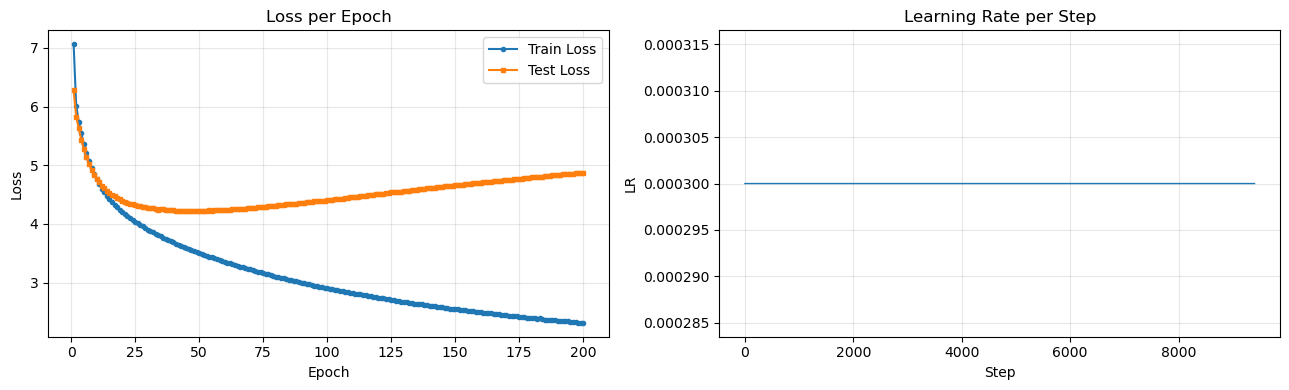

In [32]:
# 可视化训练曲线（Train/Test Loss 与 LR）
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
epochs = range(1, len(train_losses)+1)
axes[0].plot(epochs, train_losses, marker='o', markersize=3, label='Train Loss')
axes[0].plot(epochs, test_losses, marker='s', markersize=3, label='Test Loss')
axes[0].set_title('Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].plot(lrs, linewidth=1)
axes[1].set_title('Learning Rate per Step')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('LR')
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
# （可选）加载检查点再进行推理
# 将 load_best 设为 True 可加载最优模型权重
load_best = True
ckpt_path = best_ckpt if load_best else last_ckpt
if ckpt_path.exists():
    ep, best = load_checkpoint(ckpt_path, model, optimizer=None)
    print(f"已加载检查点: {ckpt_path} | epoch={ep} | best_loss={best}")
else:
    print(f"未找到检查点: {ckpt_path}")

已加载检查点: d:\xry\yanjiusheng\1\DAMOXING\lab1\t5\checkpoints\best.pt | epoch=48 | best_loss=4.2213847523643855


In [34]:
tests = [
    "What was the result",
    "It's a crisis",
    "how are you",
    "see you",
    "Sound familiar? Right",
    "Thank you very much"
 ]
for i, s in enumerate(tests, 1):
    zh = greedy_decode(model, s)
    print(f"这是第{i}条输出：{s} -> {zh}")

这是第1条输出：What was the result -> 什么？
这是第2条输出：It's a crisis -> 这是一个非常简单。
这是第3条输出：how are you -> 你们怎么？
这是第4条输出：see you -> 你看到了。
这是第5条输出：Sound familiar? Right -> 他们说。
这是第6条输出：Thank you very much -> 非常感谢。
